
**Code Initialization: Importing Libraries and Setting Computational Device**


In [ ]:
import random
import pickle
import numpy as np
import kagglehub
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from tqdm import tqdm
from PIL import Image
from torchvision.transforms import InterpolationMode
import kagglehub
import zipfile

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


**Dataset download**


In [ ]:
# Download latest version
path = kagglehub.dataset_download("dansbecker/5-celebrity-faces-dataset")

print("Path to dataset files:", path)

100%|██████████| 5.03M/5.03M [00:00<00:00, 39.3MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/dansbecker/5-celebrity-faces-dataset/versions/3


**Unzipp the dataset**

In [ ]:
dataset_zip_path = "./datasets/5-celebrity-faces-dataset.zip"
unzip_dir = "./datasets/5-celebrity-faces-dataset"

# Ensure the output directory exists
os.makedirs(unzip_dir, exist_ok=True)

# Unzip the dataset
with zipfile.ZipFile(dataset_zip_path, 'r') as zip_ref:
    zip_ref.extractall(unzip_dir)

print(f"Dataset unzipped successfully to {unzip_dir}")

Dataset unzipped successfully to ./datasets/5-celebrity-faces-dataset


**Data check**

In [ ]:
dataset_path = "./datasets/5-celebrity-faces-dataset"

# List the contents of the dataset directory
dataset_contents = os.listdir(dataset_path)
# Print the structure of the dataset
print(f"Dataset contents at '{dataset_path}':")
for item in dataset_contents:

    item_path = os.path.join(dataset_path, item)

    if os.path.isdir(item_path):

        print(f"Folder: {item}")

        sub_contents = os.listdir(item_path)

        print(f"  Contains {len(sub_contents)} items (e.g., {sub_contents[:3]}...)")

    else:

        print(f"File: {item}")

Dataset contents at './datasets/5-celebrity-faces-dataset':
Folder: data
  Contains 2 items (e.g., ['train', 'val']...)
Folder: train
  Contains 5 items (e.g., ['ben_afflek', 'elton_john', 'jerry_seinfeld']...)
Folder: val
  Contains 5 items (e.g., ['ben_afflek', 'elton_john', 'jerry_seinfeld']...)


**Check the folder contains**

In [ ]:
# Define dataset path
dataset_path = "./datasets/5-celebrity-faces-dataset"
folders = ['train', 'val']

# Count images in each subfolder
folder_image_counts = {}
for folder in folders:
    folder_path = os.path.join(dataset_path, folder)
    subfolders = os.listdir(folder_path)
    folder_image_counts[folder] = {
        subfolder: len(os.listdir(os.path.join(folder_path, subfolder))) for subfolder in subfolders
    }

folder_image_counts


{'train': {'ben_afflek': 14,
  'elton_john': 17,
  'jerry_seinfeld': 21,
  'madonna': 19,
  'mindy_kaling': 22},
 'val': {'ben_afflek': 5,
  'elton_john': 5,
  'jerry_seinfeld': 5,
  'madonna': 5,
  'mindy_kaling': 5}}

**Hyperparameter Configuration and Experiment Setup**

In [ ]:
# Set the dataset path
DATA_PATH = os.path.join(dataset_path, "5-celebrity-faces-dataset")
TRAIN_PATH = os.path.join(DATA_PATH, "train")
VAL_PATH = os.path.join(DATA_PATH, "val")
DATA_PATH = "./datasets/5-celebrity-faces-dataset"
print("Dataset downloaded and extracted successfully!")
print("Path to training dataset:", TRAIN_PATH)
print("Path to validation dataset:", VAL_PATH)

# Hyperparameters
IMG_SIZE = 128  # Resized image dimensions
BATCH_SIZE = 32  # Optimized for triplet loss training
TRAINABLE_LAYERS = 60  # Number of trainable layers in the network
LEARNING_RATE = 1e-4  # Learning rate
MAX_NUM_PER_CAT = 22  # Use a maximum of 22 samples per class for training
MAX_NUM_PER_TEST_CAT = 5  # Use a maximum of 5 samples per class for testing
EPOCHS = 50  # Number of epochs for training
MARGIN = 1.0  # Triplet loss margin

# Experiment identifier
EXPERIMENT_ID = f'celebrity_faces_imgsize_{IMG_SIZE}_bs_{BATCH_SIZE}_epochs_{EPOCHS}_margin_{MARGIN}'.replace('.', '_')

# Print the configuration
print("Hyperparameters:")
print(f"Image Size: {IMG_SIZE}")
print(f"Batch Size: {BATCH_SIZE}")
print(f"Epochs: {EPOCHS}")
print(f"Learning Rate: {LEARNING_RATE}")
print(f"Triplet Loss Margin: {MARGIN}")
print(f"Dataset located at: {DATA_PATH}")


Dataset downloaded and extracted successfully!
Path to training dataset: ./datasets/5-celebrity-faces-dataset/5-celebrity-faces-dataset/train
Path to validation dataset: ./datasets/5-celebrity-faces-dataset/5-celebrity-faces-dataset/val
Hyperparameters:
Image Size: 128
Batch Size: 32
Epochs: 50
Learning Rate: 0.0001
Triplet Loss Margin: 1.0
Dataset located at: ./datasets/5-celebrity-faces-dataset


**Data augmentation and preprocessing**

In [ ]:
augmentation = transforms.Compose([
    transforms.RandomApply([transforms.ColorJitter(contrast=0.4)], p=0.5), #Adjusts the contrast of the image
    transforms.RandomHorizontalFlip(), #Flips the image horizontally with a probability of 0.5
    transforms.RandomVerticalFlip(), #Flips the image vertically with a probability of 0.5
    transforms.RandomRotation(20, interpolation=InterpolationMode.BILINEAR), #Rotates the image randomly within ±20 degrees
    transforms.RandomApply([transforms.ColorJitter(brightness=0.2)], p=0.5),
])

preprocess = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)), #Resizes the image to the dimensions (IMG_SIZE, IMG_SIZE). Ensures all images have the same size, which is necessary for batch processing in neural networks.
    transforms.ToTensor() #Converts the image from a PIL Image (or NumPy array) to a PyTorch tensor. Normalizes the pixel values to the range [0, 1] by dividing by 255.
])
# Function to augment an image
def augment(image_path):
    from PIL import Image
    image = Image.open(image_path)
    return augmentation(image)

In [ ]:
# Dataset class
class TripletDataset(Dataset):
    def __init__(self, triplet_list, path, transform=None, preprocess=None):
        self.triplet_list = triplet_list
        self.path = path
        self.transform = transform #Augmentation transformations applied to the images
        self.preprocess = preprocess # Preprocessing transformations

    def __len__(self):
        return len(self.triplet_list) #Returns the number of triplets in the dataset

    def __getitem__(self, idx):
        a, p, n = self.triplet_list[idx]
        anchor = self.read_image(a)
        positive = self.read_image(p)
        negative = self.read_image(n)

        if self.transform:
            anchor = self.transform(anchor)
            positive = self.transform(positive)
            negative = self.transform(negative)

        if self.preprocess:
            anchor = self.preprocess(anchor)
            positive = self.preprocess(positive)
            negative = self.preprocess(negative)

        return anchor, positive, negative

    def read_image(self, file): #Input: A file name (file) corresponding to an image
        path = os.path.join(self.path, file) #Constructs the full file path using os.path.join.
        image = Image.open(path).convert('RGB') #Opens the image using PIL (Image.open) and converts it to RGB format.
        return image

**Split dataset**

In [ ]:
def split_dataset(directory, split=0.9):
    # Filter only valid subdirectories
    folders = [name for name in os.listdir(directory) if os.path.isdir(os.path.join(directory, name))]
    num_train = int(len(folders) * split)
    random.shuffle(folders)
    train_list, test_list = folders[:num_train], folders[num_train:]
    return train_list, test_list


train_list, test_list = split_dataset(DATA_PATH, split=0.9)

**Create triplets**

In [ ]:
def create_triplets(directory, categories, max_files=20):
    triplets = []
    for category in tqdm(categories, desc="Processing Categories"):
        path = os.path.join(directory, category)
        files = list(os.listdir(path))[:max_files]  # Limit to max_files
        num_files = len(files)

        # Skip categories with fewer than 2 files
        if num_files < 2:
            print(f"Skipping category {category} (fewer than 2 images).")
            continue

        for i in range(num_files):
            for j in range(num_files):
                if i == j:
                    continue

                # Define anchor and positive samples
                anchor = os.path.join(category, files[i])
                positive = os.path.join(category, files[j])

                # Sample a negative category
                negative_category = random.choice([cat for cat in categories if cat != category])
                negative_path = os.path.join(directory, negative_category)
                negative_files = os.listdir(negative_path)

                # Skip if no negative files are found
                if not negative_files:
                    print(f"No images found in negative category {negative_category}. Skipping.")
                    continue

                # Define a negative sample
                negative = os.path.join(negative_category, random.choice(negative_files))

                # Append the triplet
                triplets.append((anchor, positive, negative))

    # Shuffle the triplets
    random.shuffle(triplets)
    return triplets


**Load or create triplets**

In [ ]:
# Flag to recreate triplets
RECREATE_TRIPLETS = False

# Paths for saving and loading triplets
resources_dir = "./resources"
os.makedirs(resources_dir, exist_ok=True)
train_triplet_path = os.path.join(resources_dir, "train_triplet.pkl")
test_triplet_path = os.path.join(resources_dir, "test_triplet.pkl")

if RECREATE_TRIPLETS:
    print("Generating training triplets...")
    train_triplet = create_triplets(os.path.join(DATA_PATH, "train"), os.listdir(os.path.join(DATA_PATH, "train")), max_files=MAX_NUM_PER_CAT)
    with open(train_triplet_path, "wb") as fp:
        pickle.dump(train_triplet, fp)
    print(f"Saved {len(train_triplet)} training triplets.")

    print("Generating testing triplets...")
    test_triplet = create_triplets(os.path.join(DATA_PATH, "val"), os.listdir(os.path.join(DATA_PATH, "val")), max_files=MAX_NUM_PER_TEST_CAT)
    with open(test_triplet_path, "wb") as fp:
        pickle.dump(test_triplet, fp)
    print(f"Saved {len(test_triplet)} testing triplets.")
else:
    print("Loading existing triplets...")
    if not os.path.exists(train_triplet_path) or not os.path.exists(test_triplet_path):
        raise FileNotFoundError("Triplet files not found. Set RECREATE_TRIPLETS = True to generate them.")

    with open(train_triplet_path, "rb") as fp:
        train_triplet = pickle.load(fp)
    print(f"Loaded {len(train_triplet)} training triplets.")

    with open(test_triplet_path, "rb") as fp:
        test_triplet = pickle.load(fp)
    print(f"Loaded {len(test_triplet)} testing triplets.")

# Create datasets and data loaders
print("Creating datasets and data loaders...")
train_dataset = TripletDataset(train_triplet, os.path.join(DATA_PATH, "train"), transform=augmentation, preprocess=preprocess)
test_dataset = TripletDataset(test_triplet, os.path.join(DATA_PATH, "val"), transform=None, preprocess=preprocess)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print("Data loaders created successfully!")


Loading existing triplets...
Loaded 1678 training triplets.
Loaded 100 testing triplets.
Creating datasets and data loaders...
Data loaders created successfully!


**Model definition**

In [ ]:
class L2NormalizationLayer(nn.Module):
    def __init__(self, axis=1):
        super(L2NormalizationLayer, self).__init__()
        self.axis = axis

    def forward(self, inputs):
        return F.normalize(inputs, p=2, dim=self.axis)

class EncoderModel(nn.Module):
    def __init__(self, pretrained_trainable_layers=27):
        super(EncoderModel, self).__init__()
        self.pretrained_model = models.convnext_large(weights=models.ConvNeXt_Large_Weights.IMAGENET1K_V1) #Loads the ConvNeXt_Large model pre-trained on the ImageNet-1K dataset (IMAGENET1K_V1 weights).
        self.pretrained_model.classifier = nn.Identity() #self.pretrained_model.classifier = nn.Identity() #Removes the final dense layers responsible for classification, turning the model into a feature extractor.
        self.pretrained_model.avgpool = nn.AdaptiveAvgPool2d((1, 1)) #Replaces the average pooling layer with nn.AdaptiveAvgPool2d((1, 1)) to ensure the output is always of shape (batch_size, channels, 1, 1), regardless of the input image size.
        self.pretrained_model.head = nn.Identity() #Replaces the head block (if present) with nn.Identity, further simplifying the model.

        # Freeze layers
        for i, param in enumerate(self.pretrained_model.parameters()): #Freezes the initial layers of the pre-trained backbone to prevent their weights from being updated during training
            if i < len(list(self.pretrained_model.parameters())) - pretrained_trainable_layers:
                param.requires_grad = False

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(1536, 512)  # Adjusted input dimensions
        self.dropout1 = nn.Dropout(0.3)
        self.bn1 = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512, 256)
        self.dropout2 = nn.Dropout(0.2)
        self.bn2 = nn.BatchNorm1d(256)
        self.fc3 = nn.Linear(256, 128)
        self.dropout3 = nn.Dropout(0.05)
        self.bn3 = nn.BatchNorm1d(128)
        self.l2_norm = L2NormalizationLayer(axis=1)

    def forward(self, x):
        x = self.pretrained_model(x)
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = self.bn1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.bn2(x)
        x = self.fc3(x)
        x = self.dropout3(x)
        x = self.bn3(x)
        x = self.l2_norm(x)
        return x

encoder = EncoderModel(pretrained_trainable_layers=TRAINABLE_LAYERS).to(device)
optimizer = optim.Adam(encoder.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=1000, T_mult=2)

# Loss function
def triplet_loss(anchor, positive, negative, margin=MARGIN):
    ap_distance = F.pairwise_distance(anchor, positive)
    an_distance = F.pairwise_distance(anchor, negative)
    loss = torch.mean(torch.clamp(ap_distance - an_distance + margin, min=0.0))
    return loss

Downloading: "https://download.pytorch.org/models/convnext_large-ea097f82.pth" to /root/.cache/torch/hub/checkpoints/convnext_large-ea097f82.pth
100%|██████████| 755M/755M [00:12<00:00, 62.9MB/s]


In [ ]:
# Evaluation function
def evaluate(encoder, dataloader):
    encoder.eval()
    ap_distances, an_distances = [], []
    with torch.no_grad():
        for anchor, positive, negative in dataloader:
            anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)
            anchor_representation = encoder(anchor)
            positive_representation = encoder(positive)
            negative_representation = encoder(negative)
            ap_distances.extend(F.pairwise_distance(anchor_representation, positive_representation).cpu().numpy())
            an_distances.extend(F.pairwise_distance(anchor_representation, negative_representation).cpu().numpy())
    test_accuracy = np.mean([np.array(ap_distances) < MARGIN, np.array(an_distances) > MARGIN])
    test_metric = np.mean(np.array(ap_distances) < np.array(an_distances))
    return test_accuracy, test_metric

In [ ]:
# Training loop
MODEL_SAVE_PATH = f"./models/Experiment{EXPERIMENT_ID}_{EPOCHS}Epochs"
os.makedirs(MODEL_SAVE_PATH, exist_ok=True)

max_acc = 0
for epoch in range(1, EPOCHS + 1):
    encoder.train()
    for anchor, positive, negative in train_loader:
        anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)
        optimizer.zero_grad()
        anchor_representation = encoder(anchor)
        positive_representation = encoder(positive)
        negative_representation = encoder(negative)
        loss = triplet_loss(anchor_representation, positive_representation, negative_representation)
        loss.backward()
        optimizer.step()
        scheduler.step()

    # Evaluate on test set
    test_accuracy, test_metric = evaluate(encoder, test_loader)
    print(f"Epoch {epoch}/{EPOCHS}, Test Accuracy: {test_accuracy:.4f}, Test Metric: {test_metric:.4f}")

    # Save model if accuracy improves
    max_acc = test_accuracy
    torch.save(encoder.state_dict(), f"{MODEL_SAVE_PATH}/encoder_epoch_{epoch}_acc_{max_acc:.4f}.pth")

Epoch 1/50, Test Accuracy: 0.5850, Test Metric: 0.8500
Epoch 2/50, Test Accuracy: 0.7400, Test Metric: 0.9000
Epoch 3/50, Test Accuracy: 0.7850, Test Metric: 0.8800
Epoch 4/50, Test Accuracy: 0.8250, Test Metric: 0.9100
Epoch 5/50, Test Accuracy: 0.8200, Test Metric: 0.9300
Epoch 6/50, Test Accuracy: 0.8550, Test Metric: 0.9500
Epoch 7/50, Test Accuracy: 0.8350, Test Metric: 0.9300
Epoch 8/50, Test Accuracy: 0.8250, Test Metric: 0.9600
Epoch 9/50, Test Accuracy: 0.8550, Test Metric: 0.9600
Epoch 10/50, Test Accuracy: 0.8050, Test Metric: 0.9600
Epoch 11/50, Test Accuracy: 0.8250, Test Metric: 0.9300
Epoch 12/50, Test Accuracy: 0.8550, Test Metric: 0.9600
Epoch 13/50, Test Accuracy: 0.8450, Test Metric: 0.9600
Epoch 14/50, Test Accuracy: 0.8350, Test Metric: 0.9500
Epoch 15/50, Test Accuracy: 0.8250, Test Metric: 0.9300
Epoch 16/50, Test Accuracy: 0.8300, Test Metric: 0.9500
Epoch 17/50, Test Accuracy: 0.8300, Test Metric: 0.9300
Epoch 18/50, Test Accuracy: 0.8150, Test Metric: 0.9300
E

**Prepare a Visualization Function**

In [ ]:


def visualize_triplet(encoder, anchor_path, positive_path, negative_path, preprocess):
    # Load and preprocess images
    anchor_img = preprocess(Image.open(anchor_path))
    positive_img = preprocess(Image.open(positive_path))
    negative_img = preprocess(Image.open(negative_path))

    # Move images to device and add batch dimension
    anchor_tensor = anchor_img.unsqueeze(0).to(device)
    positive_tensor = positive_img.unsqueeze(0).to(device)
    negative_tensor = negative_img.unsqueeze(0).to(device)

    # Get embeddings
    encoder.eval()
    with torch.no_grad():
        anchor_embedding = encoder(anchor_tensor)
        positive_embedding = encoder(positive_tensor)
        negative_embedding = encoder(negative_tensor)

    # Calculate cosine similarities
    pos_similarity = F.cosine_similarity(anchor_embedding, positive_embedding).item()
    neg_similarity = F.cosine_similarity(anchor_embedding, negative_embedding).item()

    # Display images and similarities
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    for ax, img, title in zip(axes,
                               [Image.open(anchor_path), Image.open(positive_path), Image.open(negative_path)],
                               [f"Anchor\n",
                                f"Positive\nSimilarity: {pos_similarity:.2f}",
                                f"Negative\nSimilarity: {neg_similarity:.2f}"]):
        ax.imshow(img)
        ax.set_title(title)
        ax.axis("off")
    plt.show()


**Visualize a Test Triplet**

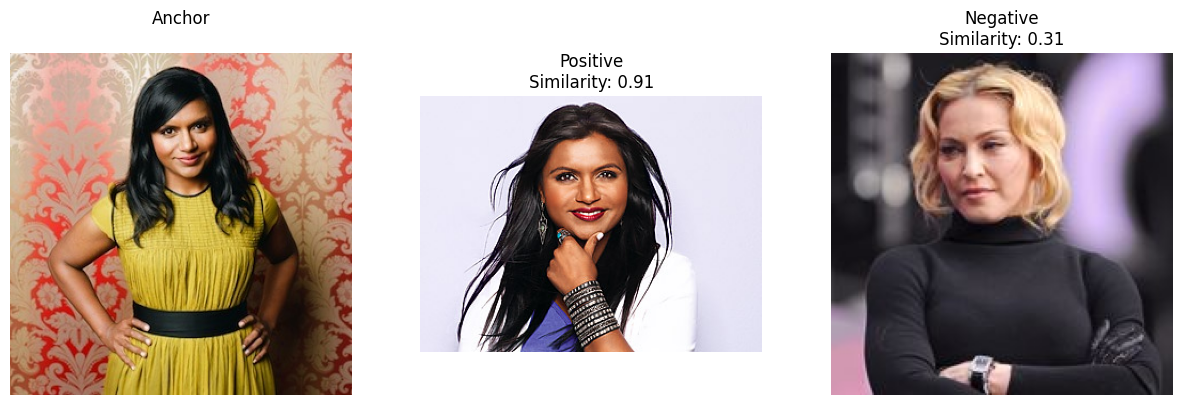

In [ ]:

example_triplet = test_triplet[0]  # First triplet in the test set
anchor_path = os.path.join(DATA_PATH, "val", example_triplet[0])
positive_path = os.path.join(DATA_PATH, "val", example_triplet[1])
negative_path = os.path.join(DATA_PATH, "val", example_triplet[2])

visualize_triplet(encoder, anchor_path, positive_path, negative_path, preprocess)
